In [13]:
import os
import datetime
import random # random.seed(42)
import warnings
import numpy as np # np.random.seed(42)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize,LinearSegmentedColormap

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import sklearn.exceptions
from sklearn.utils import class_weight
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

from tensorflow.config.experimental import enable_op_determinism # enable_op_determinism()
from tensorflow.random import set_seed # set_seed(42)
from tensorflow.python.client import device_lib

from keras import backend as K
from keras.utils import load_img, img_to_array, set_random_seed # set_random_seed(42)
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.layers import Input, GlobalAveragePooling2D, ZeroPadding2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import applications

from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
import itertools

import keras
from keras.applications import ResNet50, Xception
from keras.models import Sequential, Model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
#from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.utils import to_categorical
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, History

np.random.seed(123)
# !conda install -y -n ml ipykernel=6.23.2 numpy==1.24.0 matplotlib=3.7.1 pandas=2.0.2 seaborn=0.12.1 scikit-learn=1.3.2 tensorflow=2.11.1
# !jupyter nbconvert --to html skin-cancer-cnn.ipynb
[x.name for x in device_lib.list_local_devices()]

['/device:CPU:0']

In [14]:
test_path = "test/test_images"
df_test = pd.read_csv('test/test_metadata.csv')
df_test = df_test[df_test['dx'] != 'vasc']
df_test = df_test[df_test['dx'] != 'df']
df_test['image_id'] = df_test['image_id'].astype(str) + '.jpg'
df_test=df_test.drop(['lesion_id', 'dataset'], axis=1)
df_test.sort_values(by=['image_id'], inplace=True)
df_test.reset_index(inplace=True, drop=True)
test_df = df_test.copy().sample(frac=1, random_state=123).reset_index(drop=True)

In [15]:
#To use augmented data
train_path = 'augmented/augmented_images'
train_df = pd.read_csv('augmented/augmented_train.csv')
val_df = pd.read_csv('augmented/augmented_val.csv')
labels = train_df['dx'].sort_values().unique()

In [16]:
for label in labels:
    list1 = len(train_df[train_df['dx'] == label]), len(val_df[val_df['dx'] == label]), len(test_df[test_df['dx'] == label])
    space = ' '
    print(label,(5-len(label))*space ,list1)
    
train_df.shape, val_df.shape, test_df.shape

akiec  (1000, 70, 43)
bcc    (1000, 70, 93)
bkl    (1011, 80, 217)
mel    (1067, 70, 171)
nv     (1100, 80, 909)


((5178, 3), (370, 3), (1433, 6))

In [17]:
rescale=1./255
color_mode = 'rgb'
target_size = (32, 32)
batch_size  = 64
# 600 x 450
train_data_np = np.array([img_to_array(load_img(train_path+'/'+img, target_size=target_size)) for img in train_df['image_id'].values.tolist()])

datagen = ImageDataGenerator(rescale=rescale,
                            featurewise_center=True,
                            featurewise_std_normalization=True)
datagen.fit(train_data_np)
train_set = datagen.flow_from_dataframe(train_df,
                                        directory=train_path,
                                        x_col="image_id",
                                        y_col="dx",
                                        color_mode=color_mode,
                                        target_size=target_size,
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=False
                                        )

val_set = datagen.flow_from_dataframe(val_df,
                                      directory=train_path,
                                      x_col="image_id",
                                      y_col="dx",
                                      color_mode=color_mode,
                                      target_size=target_size,
                                      batch_size=batch_size,
                                      class_mode='categorical',
                                      shuffle=False
                                      )
test_set = datagen.flow_from_dataframe(test_df,
                                       directory=test_path,
                                       x_col="image_id",
                                       y_col="dx",
                                       color_mode=color_mode,
                                       target_size=target_size,
                                       batch_size=batch_size,
                                       class_mode='categorical',
                                       shuffle=False
                                       )

Found 5178 validated image filenames belonging to 5 classes.
Found 370 validated image filenames belonging to 5 classes.
Found 1432 validated image filenames belonging to 5 classes.


c:\Users\bekir\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((60,45))))

features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

# Create First Train and Test sets
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)

#The normalisation is done using the training set Mean and Std. Deviation as reference
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_train_mean)/x_train_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

#Splitting training into Train and Validatation sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1,random_state=123)

#Reshaping the Images into 3 channels (RGB)
x_train = x_train.reshape(x_train.shape[0], *(45, 60, 3))
x_test = x_test.reshape(x_test.shape[0], *(45, 60, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(45, 60, 3))

In [ ]:
no_of_classes = len(labels)
#Model Parameters
input_shape = (45, 60, 3)
num_classes = 7

optimizer = tf.keras.optimizers.legacy.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

epochs = 50
batch_size = 20

#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')

#Data Augmentation
dataaugment = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

dataaugment.fit(x_train)

def history(model):
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                        epochs = epochs, validation_data = (x_validate,y_validate),
                        verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor])

    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    predictions = model.predict(x_test)
    loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
    loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=0)
    return (predictions,accuracy_t,accuracy_v,accuracy)

In [18]:
num_classes = len(labels)

base_model = ResNet50(include_top=False, input_shape=(45,60, 3),pooling = 'avg', weights = 'imagenet');

ResNet50model = Sequential()
ResNet50model.add(base_model)
ResNet50model.add(Dropout(0.2))
ResNet50model.add(Dense(128, activation="relu"))
ResNet50model.add(Dropout(0.2))
ResNet50model.add(Dense(num_classes, activation = 'softmax'))

ResNet50model.summary()
###################################

'''
for layer in base_model.layers:
    layer.trainable = True

ResNet50y_pred,ResNet50accuracy_t,ResNet50accuracy_v,ResNet50accuracy = history(ResNet50model)
    
print("ResNet50 Training: accuracy = %f" % (ResNet50accuracy_t))
print("ResNet50 Validation: accuracy = %f" % (ResNet50accuracy_v))
print("ResNet50 Test: accuracy = %f" % (ResNet50accuracy))
'''



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 23850629 (90.98 MB)
Trainable params: 23797509 (90.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


'\nfor layer in base_model.layers:\n    layer.trainable = True\n\nResNet50y_pred,ResNet50accuracy_t,ResNet50accuracy_v,ResNet50accuracy = history(ResNet50model)\n    \nprint("ResNet50 Training: accuracy = %f" % (ResNet50accuracy_t))\nprint("ResNet50 Validation: accuracy = %f" % (ResNet50accuracy_v))\nprint("ResNet50 Test: accuracy = %f" % (ResNet50accuracy))\n'

In [19]:
def loss_plot(model, history, now, save=True):
    # convert the history.history dict to a pandas DataFrame:
    if type(history) is not pd.DataFrame:
        history = pd.DataFrame(history)
    if save == True:
        hist_csv_file = f'model-comparison/{now}/history.csv'
        with open(hist_csv_file, mode='w') as f:
            history.to_csv(f) 
    epochs = range(1, history.shape[0]+1)
    plt.figure(figsize=(5, 2))
    plt.plot(epochs, history['accuracy'], label='Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    max_val_acc_epoch = np.argmax(history['val_accuracy']) + 1
    max_val_acc = history['val_accuracy'][max_val_acc_epoch-1]
    label='Best Epoch = '+str(max_val_acc_epoch)+'\nVal. Acc. = '+str((max_val_acc*100).round(2))+ '%'
    plt.plot(max_val_acc_epoch, max_val_acc, 'ro', label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xlim([0, history.shape[0]+0.1])
    plt.ylim([0.5, 1])
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='upper left')
    if save == True:
        plt.savefig(f'model-comparison/{now}/val-acc.png')
        np.savetxt('model-comparison/{}/{}.txt'.format(now,str((max_val_acc*100).round(2))), [max_val_acc], fmt='%f')
        stats = str(now) + ' ' + str((max_val_acc*100).round(2)) + '\n'
        with open('model-comparison/best-models.txt', 'a') as f:
            f.write(stats)
    plt.show()

In [20]:
def EvaluateModel(model, test_set, str1, now, save = True):
    
    print('\n PREDICTING LABELS OF TEST IMAGES')
    result = model.predict(test_set)
    y_pred = np.argmax(result, axis=1)
    
    if save==True:
        #save y_pred to csv file
        os.mkdir('model-comparison/'+now+'/'+str1)
        np.savetxt('model-comparison/{}/{}/pred.csv'.format(now,str1), y_pred, delimiter=',', fmt='%d')
    
    y_true = test_set.classes # List containing true labels for each image.

    # Understanding classification power of model on each class    
    report = classification_report(y_true, y_pred, target_names=test_set.class_indices.keys())
    report_d = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, target_names=test_set.class_indices.keys())).transpose()
    report_d['support']['accuracy'] = report_d['support']['macro avg']

    annot = report_d.copy()
    annot.iloc[:, 0:3] = (annot.iloc[:, 0:3]*100).applymap('{:.2f}'.format) + ' %'
    annot.iloc[7, 1] = ''
    annot.iloc[7, 0] = ''
    annot['support'] = annot['support'].astype(int)

    # how to save report as image
    norm = Normalize(-1,1)
    cmap = LinearSegmentedColormap.from_list("", [[norm(-1.0), "white"],[norm( 1.0), "white"]])
    plot = sns.heatmap(report_d, annot=annot, cmap=cmap, cbar=False, fmt='')
    fig = plot.get_figure()
    if save==True:
        fig.savefig('model-comparison/{}/{}/report.png'.format(now,str1))
    
    f1_score = ((report_d['f1-score']['weighted avg']*100000//10)/100)
    accuracy = ((report_d['f1-score']['accuracy']*100000//10)/100)
    print('\nAccuracy of model prediction is: {:.2f} %'.format(accuracy))
    print('\nF1-score of model prediction is: {:.2f} %'.format(f1_score))

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=test_set.class_indices.keys()
                              )
    disp.plot(cmap='Reds')
    disp.ax_.set_title('Confusion Matrix')
    plt.show()
    if save==True:
        disp.figure_.savefig('model-comparison/{}/{}/cm.png'.format(now,str1))

In [28]:
def train_new_model(model):
    # Extra
    #class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(train_set.classes), y=train_set.classes)
    #class_weights_dict=dict(zip(np.unique(train_set.classes),class_weights))
    #keras.utils.set_random_seed(42)     
    # inside model.fit: class_weight=class_weights_dict,

    # Train new model and evaluate
    now = datetime.datetime.now().strftime("%d-%m-%H-%M")
    os.mkdir('model_comparison/'+now)
    def myprint(s):
        with open(f'model_comparison/{now}/modelsummary.txt','a') as f:
            print(s, file=f)
    model.summary(print_fn=myprint)
    with open('model_comparison/last.txt', 'w') as f:
        f.write(str(now))
    return now

c:\Users\bekir\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/15


81/81 [==============================] - ETA: 0s - loss: 1.1467 - accuracy: 0.6118

c:\Users\bekir\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 236s 2s/step - loss: 1.1467 - accuracy: 0.6118 - val_loss: 902.9116 - val_accuracy: 0.2162 - lr: 0.0010
Epoch 2/15
81/81 [==============================] - 155s 2s/step - loss: 0.7331 - accuracy: 0.7346 - val_loss: 2.3234 - val_accuracy: 0.2162 - lr: 0.0010
Epoch 3/15
81/81 [==============================] - 144s 2s/step - loss: 0.6062 - accuracy: 0.7847 - val_loss: 2.0412 - val_accuracy: 0.2622 - lr: 0.0010
Epoch 4/15
81/81 [==============================] - 131s 2s/step - loss: 0.5501 - accuracy: 0.8075 - val_loss: 122.8485 - val_accuracy: 0.2162 - lr: 0.0010
Epoch 5/15
81/81 [==============================] - 107s 1s/step - loss: 0.4509 - accuracy: 0.8358 - val_loss: 1.8908 - val_accuracy: 0.3514 - lr: 0.0010
Epoch 6/15
81/81 [==============================] - 107s 1s/step - loss: 0.3940 - accuracy: 0.8573 - val_loss: 2.7347 - val_accuracy: 0.4027 - lr: 0.0010
Epoch 7/15
81/81 [==============================] - 104s 1s/step - loss: 0.3307 - a

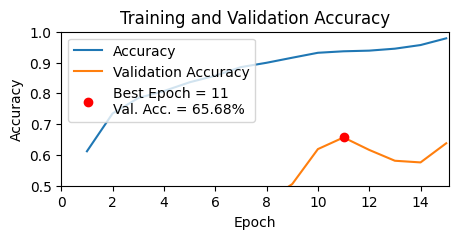


 PREDICTING LABELS OF TEST IMAGES
6/6 [==============================] - 8s 495ms/step


C:\Users\bekir\AppData\Local\Temp\ipykernel_21604\2494306443.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot.iloc[:, 0:3] = (annot.iloc[:, 0:3]*100).applymap('{:.2f}'.format) + ' %'



Accuracy of model prediction is: 65.67 %

F1-score of model prediction is: 64.76 %


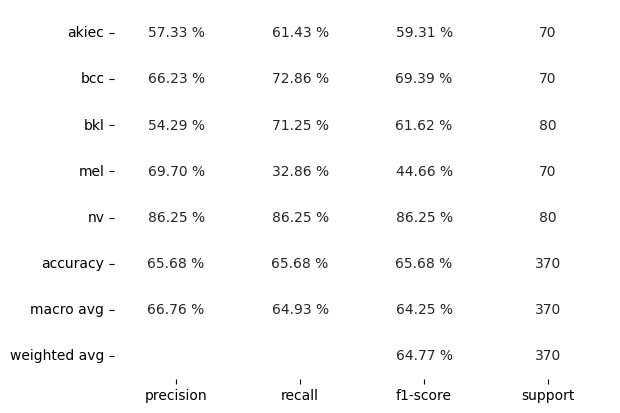

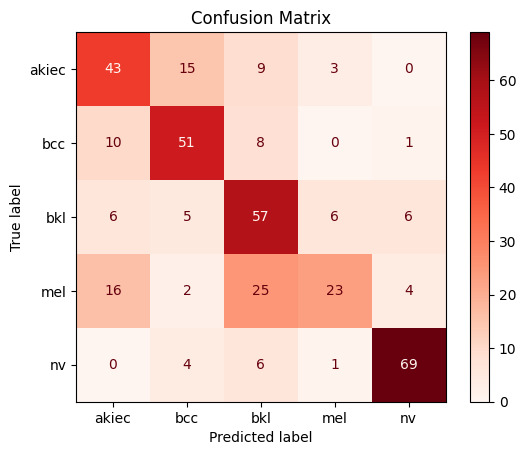


 PREDICTING LABELS OF TEST IMAGES
23/23 [==============================] - 86s 4s/step


C:\Users\bekir\AppData\Local\Temp\ipykernel_21604\2494306443.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot.iloc[:, 0:3] = (annot.iloc[:, 0:3]*100).applymap('{:.2f}'.format) + ' %'



Accuracy of model prediction is: 59.07 %

F1-score of model prediction is: 62.58 %


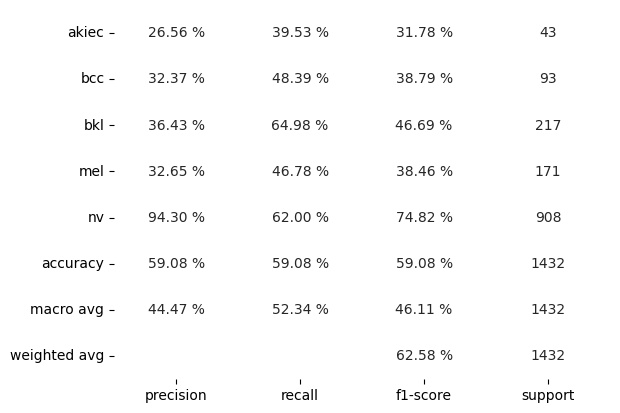

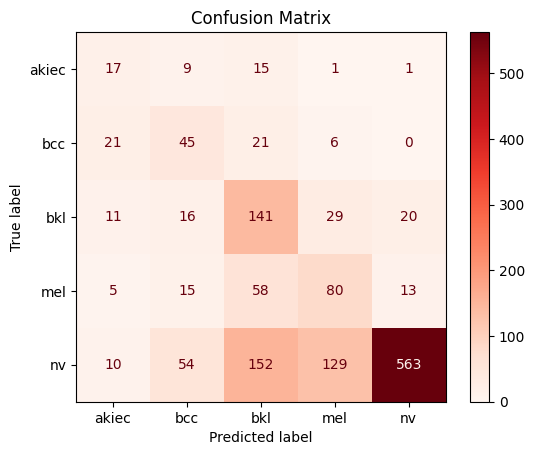

In [29]:
now = train_new_model(ResNet50model)

# Define the optimizer
#optimizer = Adam(learning_rate=0.01*(batch_size/256), beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
optimizer = tf.keras.optimizers.legacy.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#optimizer = SGD(learning_rate=0.01*(batch_size/256), momentum=0.9, nesterov=True)
ResNet50model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0000001)
checkpoint = ModelCheckpoint(f"model-comparison/{now}/model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True)

history = ResNet50model.fit(train_set,
                    epochs=15,
                    validation_data = val_set,
                    callbacks=[reduce_lr, checkpoint, early_stop],
                    )

loss_plot(ResNet50model, history.history, now)

model = load_model(f"model-comparison/{now}/model.h5")
EvaluateModel(model, val_set, 'val', now)
EvaluateModel(model, test_set, 'test', now)